In [6]:
from sklearn.metrics import roc_curve, auc

from predictor.models import AkiGpt2, AkiLstm
from predictor.utils import convert_preds

import matplotlib.pyplot as plt
import numpy as np
import torch

In [7]:
test_matrix = np.load('../dataset/matrix_testing.npy')
test_x = torch.tensor(test_matrix[:, :, :-1], dtype=torch.float32)
test_y = torch.tensor(test_matrix[:, :, -1:], dtype=torch.float32)

In [8]:
model = AkiGpt2(n_heads=2, timesteps=8, n_features=16, n_layers=3)
state_dict = torch.load('../saved_models/gpt2_e50_l3.pt', map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.eval()

y_hat, _ = model(test_x)
y, y_hat = convert_preds(test_x, test_y, y_hat)
gpt2_fpr, gpt2_tpr, _ = roc_curve(y, y_hat)
gpt2_auc = auc(gpt2_fpr, gpt2_tpr)

In [9]:
model = AkiLstm(timesteps=8, n_features=16, n_layers=3)
state_dict = torch.load('../saved_models/lstm_e50_l3.pt', map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.eval()

y_hat, _ = model(test_x)
y, y_hat = convert_preds(test_x, test_y, y_hat)
lstm_fpr, lstm_tpr, _ = roc_curve(y, y_hat)
lstm_auc = auc(lstm_fpr, lstm_tpr)

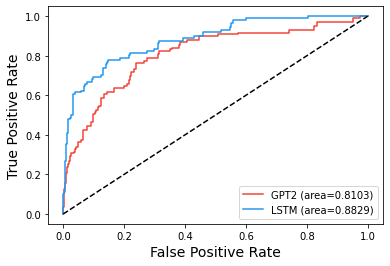

In [10]:
plt.plot(gpt2_fpr, gpt2_tpr, label=f'GPT2 (area={gpt2_auc:.4f})', color='#F44336')
plt.plot(lstm_fpr, lstm_tpr, label=f'LSTM (area={lstm_auc:.4f})', color='#2196F3')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc='lower right')
plt.show()